In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the Data

In [2]:
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv")

In [3]:
print("Shape : ", df.shape)
df.head()

Shape :  (5000, 14)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


#### Data Cleaning and Feature Engineering

In [5]:
# Deleting Columns which are not necessary
df.drop(["ID", "ZIP Code"],axis=1,inplace=True)

In [6]:
print("Duplicate : ", df.duplicated().sum())
print("Null : ", df.isnull().sum().sum())

Duplicate :  13
Null :  0


In [7]:
print(df["Experience"].unique())
df["Experience"] = abs(df["Experience"])

[ 1 19 15  9  8 13 27 24 10 39  5 23 32 41 30 14 18 21 28 31 11 16 20 35
  6 25  7 12 26 37 17  2 36 29  3 22 -1 34  0 38 40 33  4 -2 42 -3 43]


In [8]:
df.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account',
       'Online', 'CreditCard'],
      dtype='object')

In [9]:
df = df[['Age', 'Experience', 'Income', 'Family', 'CCAvg','Education', 'Mortgage', 'Securities Account','CD Account', 'Online', 'CreditCard', 'Personal Loan']]

In [10]:
X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values

### SMOTE - Synthetic Minority Oversampling Technique

In [11]:
df["Personal Loan"].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

There is a need for SMOTE since the positive class only has 480 datapoints.

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=69)
x_res,y_res = smote.fit_resample(X,Y)

In [13]:
from sklearn.decomposition import PCA

pca_1 = PCA(n_components=2)
pca_2 = PCA(n_components=2)

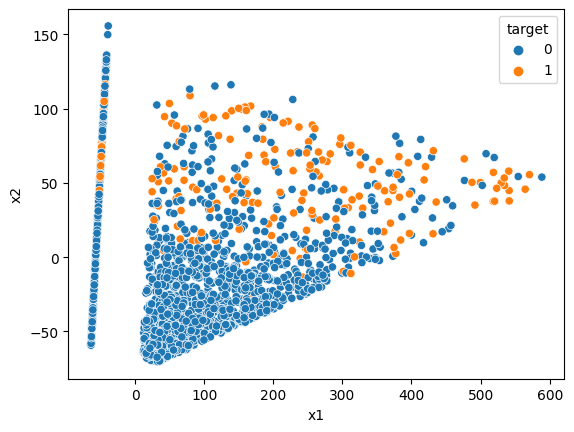

In [14]:
# Before SMOTE

reduced = pd.DataFrame(pca_1.fit_transform(X),columns=["x1","x2"])
target = pd.DataFrame(Y,columns=["target"])
reduced = pd.concat([reduced,target],axis=1)

sns.scatterplot(reduced,x="x1",y="x2",hue="target")
plt.show()

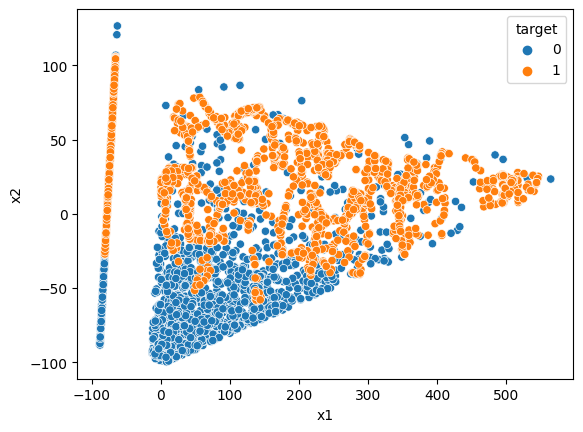

In [15]:
# After SMOTE

reduced = pd.DataFrame(pca_2.fit_transform(x_res),columns=["x1","x2"])
target = pd.DataFrame(y_res,columns=["target"])
reduced = pd.concat([reduced,target],axis=1)

sns.scatterplot(reduced,x="x1",y="x2",hue="target")
plt.show()

### Train Test Split

In [16]:
x,y = X,Y

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=69)

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [19]:
x_train.shape, y_train.shape

((3750, 11), (3750,))

# PyTorch 

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [21]:
BATCH_SIZE = 32
LEARNING_RATE = 0.003
EPOCH = 50

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
train_x = torch.from_numpy(x_train).to(torch.float32)
train_y = torch.from_numpy(y_train).to(torch.float32)

In [24]:
train_x.shape, train_y.shape

(torch.Size([3750, 11]), torch.Size([3750]))

In [25]:
data = TensorDataset(train_x,train_y)
data = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True)

## Building Model

In [26]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model,self).__init__()
        
        self.layer1 = torch.nn.Linear(11,16)
        self.layer2 = torch.nn.Linear(16,1)
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

In [27]:
model = Model()
# model.to(device)
print(model)

Model(
  (layer1): Linear(in_features=11, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


## Defining Loss function and Optimizer

In [28]:
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

## Training

In [29]:
training_loss = [0]*EPOCH
training_accuracy = [0]*EPOCH

for i in range(1,EPOCH+1):
    epoch_loss = 0
    accuracy = 0
    for x_batch,y_batch in data:
        # x_batch,y_batch = x_batch.to(device),y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(x_batch)
        
        loss = loss_function(y_pred,y_batch.unsqueeze(1))
        loss.backward()
        
        optimizer.step()
        epoch_loss += loss.item() * len(x_batch)
        cnt = (torch.where(y_pred>=0.5, 1, 0) == y_batch.unsqueeze(1)).sum().float()
        accuracy += cnt.item()
    if(i%10 == 0):
        print(i,epoch_loss/len(data.dataset),(accuracy)/len(data.dataset))

10 0.06543040360858043 0.9765333333333334
20 0.054478503256042796 0.9816
30 0.04920049545566241 0.9824
40 0.04567213552743196 0.9853333333333333
50 0.04374659665425618 0.9853333333333333


## Testing 

In [30]:
test_x = torch.from_numpy(x_test).to(torch.float32)
test_y = torch.from_numpy(y_test).to(torch.float32)

In [31]:
test = TensorDataset(test_x,test_y)
test = DataLoader(test,batch_size=1)

In [32]:
y_pred = model(test_x)
y_pred = torch.where(y_pred>=0.5, 1, 0).flatten()
accuracy = (y_pred == test_y).sum().float().item() / len(test.dataset)
print(accuracy)

0.9824


### Classification Report

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1135
           1       0.90      0.90      0.90       115

    accuracy                           0.98      1250
   macro avg       0.95      0.95      0.95      1250
weighted avg       0.98      0.98      0.98      1250



# Keras

In [34]:
import tensorflow as tf
from tensorflow import keras

### Model Building and Training 

In [35]:
model = keras.Sequential(
        [keras.layers.Dense(16,activation=tf.nn.relu),
         keras.layers.Dense(1,activation=tf.nn.sigmoid)
        ])

In [36]:
opt = keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=["accuracy"],)

In [37]:
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
118/118 [==============================] - 1s 993us/step - loss: 0.3721 - accuracy: 0.8499
Epoch 2/50
118/118 [==============================] - 0s 857us/step - loss: 0.1683 - accuracy: 0.9368
Epoch 3/50
118/118 [==============================] - 0s 889us/step - loss: 0.1222 - accuracy: 0.9555
Epoch 4/50
118/118 [==============================] - 0s 889us/step - loss: 0.1004 - accuracy: 0.9653
Epoch 5/50
118/118 [==============================] - 0s 855us/step - loss: 0.0884 - accuracy: 0.9693
Epoch 6/50
118/118 [==============================] - 0s 855us/step - loss: 0.0812 - accuracy: 0.9723
Epoch 7/50
118/118 [==============================] - 0s 889us/step - loss: 0.0763 - accuracy: 0.9731
Epoch 8/50
118/118 [==============================] - 0s 889us/step - loss: 0.0721 - accuracy: 0.9747
Epoch 9/50
118/118 [==============================] - 0s 957us/step - loss: 0.0695 - accuracy: 0.9755
Epoch 10/50
118/118 [==============================] - 0s 821us/step - loss: 0.066

## Testing

In [38]:
model.evaluate(x_test,y_test)

40/40 [==============================] - 0s 1ms/step - loss: 0.0566 - accuracy: 0.9808


[0.05659639462828636, 0.9807999730110168]

In [39]:
y_pred = model.predict(x_test)

40/40 [==============================] - 0s 810us/step


In [40]:
y_pred[np.where(y_pred >= 0.5)] = 1
y_pred[np.where(y_pred < 0.5)] = 0
y_pred = y_pred.flatten()

In [41]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1131
         1.0       0.91      0.88      0.90       119

    accuracy                           0.98      1250
   macro avg       0.95      0.94      0.94      1250
weighted avg       0.98      0.98      0.98      1250

